In [24]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from textblob import TextBlob as blob
from scipy import stats
from pymongo import MongoClient
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import sentiment as vaderSentiment 

# sentiment analysis
from textblob.sentiments import NaiveBayesAnalyzer
from pattern.en import sentiment, mood, modality, wordnet, ADJECTIVE

# text parsing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from spacy.en import English, STOPWORDS
from nltk.tokenize import sent_tokenize, word_tokenize

# modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
import lda
from sklearn.decomposition import PCA, LatentDirichletAllocation

# visualization
import pyLDAvis

%matplotlib inline

In [58]:
from pymongo import MongoClient

client = MongoClient()
db = client.test

# pull tweets out of mongo
def out_of_mongo(collection):
    tweet_list = []
    for tweet in collection.find():
        tweet_list.append(tweet)
    return tweet_list

In [59]:
# trump data
dt_data = out_of_mongo(db.trumptweets)

In [90]:

# convert to pandas df
def data_to_df(data):
    """Convert list object of tweet data into dataframe; keep only important columns.
    Args:
    data (list of dict, json) -- tweet data
    name (string) -- name of candidate, used to populate candidate column
    """
    # variables explained: https://dev.twitter.com/overview/api/tweets
    df = pd.DataFrame(data)
    df.drop_duplicates(subset = 'id', inplace = True)
    keep = ['id', 'created_at', 'text', 
            'favorite_count', 'retweet_count',  
            'is_quote_status', 'quoted_status', 'quoted_status_id', 
            'in_reply_to_screen_name', 'in_reply_to_status_id', 'retweeted_status', 
            'entities']
    df = df[keep]
    return df

dt = data_to_df(dt_data)

In [84]:
dt.describe()

,id,favorite_count,retweet_count,quoted_status_id
count,4.000000e+02,400.000000,400.000000,7.000000e+00
mean,7.528289e+17,24214.367500,8616.720000,7.470601e+17
std,6.850656e+15,13494.178216,4909.325109,6.370550e+15
min,7.423718e+17,0.000000,1971.000000,7.438980e+17
25%,7.462897e+17,14598.000000,5074.250000,NaN
50%,7.536299e+17,22324.000000,7682.000000,NaN
75%,7.591915e+17,30657.750000,10536.250000,NaN
max,7.622845e+17,83230.000000,31203.000000,7.612773e+17


In [91]:
dt.head()

,id,created_at,text,favorite_count,retweet_count,is_quote_status,quoted_status,quoted_status_id,in_reply_to_screen_name,in_reply_to_status_id,retweeted_status,entities
0,762284533341417472,Sun Aug 07 13:49:29 +0000 2016,I see where Mayor Stephanie Rawlings-Blake of ...,18689,6343,False,NaN,NaN,None,None,NaN,"{u'symbols': [], u'user_mentions': [], u'hasht..."
1,762110918721310721,Sun Aug 07 02:19:37 +0000 2016,"Thank you Windham, New Hampshire! #TrumpPence1...",15984,4818,False,NaN,NaN,None,None,NaN,"{u'symbols': [], u'user_mentions': [], u'hasht..."
2,762106904436961280,Sun Aug 07 02:03:39 +0000 2016,.@Larry_Kudlow - 'Donald Trump Is the middle-c...,16312,6547,False,NaN,NaN,None,None,NaN,"{u'symbols': [], u'user_mentions': [{u'indices..."
3,762104411707568128,Sun Aug 07 01:53:45 +0000 2016,I am not just running against Crooked Hillary ...,60500,19862,False,NaN,NaN,None,None,NaN,"{u'symbols': [], u'user_mentions': [], u'hasht..."
4,762016426102296576,Sat Aug 06 20:04:08 +0000 2016,#CrookedHillary is not fit to be our next pres...,21357,7160,False,NaN,NaN,None,None,NaN,"{u'symbols': [], u'user_mentions': [], u'hasht..."


In [86]:
def is_retweet(retweeted_status):
    """Check if tweet is retweet."""
    try:
        if np.isnan(retweeted_status) == True:
            return 
    except:
        return 1
    
def get_week(date):
    """Return start of week (Monday) given a date."""
    week = date - timedelta(days = date.weekday())
    return week

def add_metadata(df):
    """Add date, is retweet, month, and week features to df."""
    # add date as datetime object
    df.loc[:, 'date'] = df.loc[:, 'created_at'].apply(lambda x: pd.to_datetime(x).date())
    
    # add if retweet
    df.loc[:, 'is_retweet'] = df.loc[:, 'retweeted_status'].apply(is_retweet)
    
    # add week
    df.loc[:, 'week'] = df.loc[:, 'date'].apply(get_week)
    
    # add month
    df.loc[:, 'month'] = df.loc[:, 'date'].apply(lambda x: x.replace(day = 1))

In [92]:
add_metadata(dt)

In [122]:
def plot_feats(df, featurelist): 
    """Plot features of dataframe
    Args:
    df (dataframe) -- dataframe
    featurelist (list) -- list of features to plot
    """    
    plt.figure(figsize = (20, 8))
    plt.title('Retweets and Favorites', fontsize = 14)
    for feature in featurelist:
        plt.plot(df[feature])
    plt.legend(loc = 'best')
    plt.show()

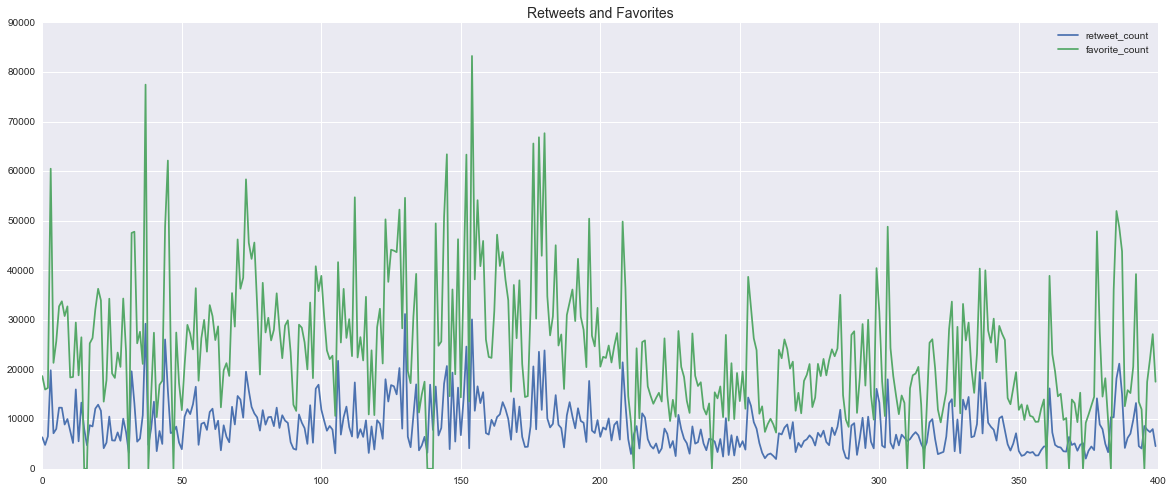

In [134]:
# compare retweets vs. favorites

plot_feats(dt, ['retweet_count', 'favorite_count'])

In [178]:
# group by date

groupby_date_fav = dt['favorite_count'].groupby(dt['date'])
groupby_date_rt = dt['retweet_count'].groupby(dt['date'])

In [181]:
meanfav_df = groupby_date_fav.mean()
meanrt_df = groupby_date_rt.mean()
meanfav_df.head()
meanrt_df.head()

date
2016-06-13     7415.090909
2016-06-14    11823.428571
2016-06-15     6144.777778
2016-06-16     4547.714286
2016-06-17     5152.000000
Name: retweet_count, dtype: float64

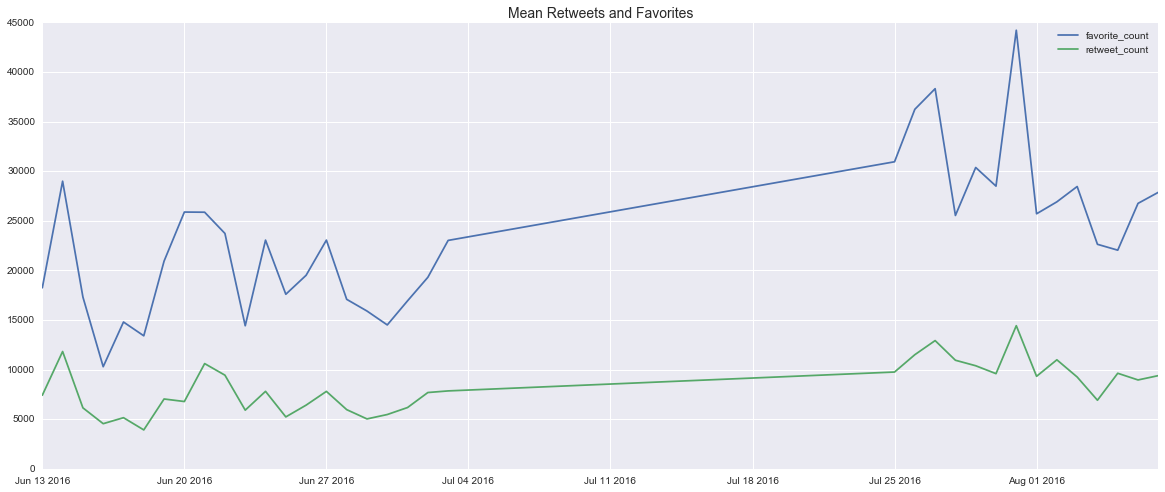

In [187]:
def plot_compare(dfs): 
    plt.figure(figsize = (20, 8))
    plt.title('Mean Retweets and Favorites', fontsize = 14)
    for df in dfs:
        plt.plot(df)
    plt.legend(loc = 'best')
    plt.show()
    
plot_compare([meanfav_df, meanrt_df])